## 1. Project Setup and Imports
This initial block sets up the project by importing all the necessary libraries. It includes TensorFlow and Keras for building the neural network, NumPy for numerical operations, and Matplotlib for visualizing the results. We also set a universal random seed to ensure that our experimental results are reproducible.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Generation and Preparation
Since real signature data is sensitive and not publicly available, we begin by creating a realistic synthetic dataset. This process involves two key steps:

**Signature Generation:** We programmatically generate individual signatures, each defined by four key features: the X and Y coordinates of the pen, the pressure applied, and the time elapsed between points (speed). Each "user" is assigned a unique base style to ensure their signatures are distinct.

**Dataset Assembly:** We then create pairs of these signatures. A "genuine" pair consists of two different signatures from the same user, while a "forged" pair consists of two signatures from different users. Finally, this data is preprocessed and split into training and validation sets,

In [2]:
def generate_synthetic_signature(base_style, noise_level=0.05, length=100):
    """
    Generates a single signature sequence.

    This function simulates a signature's dynamic features (x, y coordinates,
    pressure, and time delta) using mathematical functions (Lissajous curves)
    and adds a layer of random noise to mimic natural human variation.
    """

     # Generate the base path of the signature using Lissajous curves.
    t = np.linspace(0, 2 * np.pi, length)
    x = np.sin(base_style['a'] * t + base_style['delta'])
    y = np.sin(base_style['b'] * t)

    # Simulate the signature's dynamics: pressure and speed (time delta).
    pressure = np.abs(np.sin(base_style['p_freq'] * t))
    dt = np.full(length, base_style['speed']) + np.random.normal(0, 0.005, length)

    # Add realistic random noise to all features.
    x += np.random.normal(0, noise_level, length)
    y += np.random.normal(0, noise_level, length)
    pressure += np.random.normal(0, noise_level / 2, length)
    pressure = np.clip(pressure, 0, 1)

    # Combine all features into a single sequence.
    signature = np.vstack([x, y, pressure, dt]).T
    return signature

def create_signature_dataset(num_users=10, samples_per_user=20, max_len=150):
    """
    Creates a full dataset of genuine-genuine and genuine-forged signature pairs.

    This function first generates a unique set of signatures for multiple
    simulated users. It then pairs these signatures to create a balanced
    dataset for training a Siamese neural network, where each pair is
    labeled as either 'genuine' (signatures from the same user) or
    'forged' (signatures from different users).
    """

    # Generate a unique base style for each user to define their signing characteristics.
    user_signatures = []
    base_styles = [
        {'a': np.random.randint(1, 4), 'b': np.random.randint(1, 4), 'delta': np.pi / np.random.randint(1, 4), 'p_freq': np.random.uniform(1, 3), 'speed': np.random.uniform(0.01, 0.05)}
        for _ in range(num_users)
    ]

    # Generate multiple signature samples for each user.
    for i in range(num_users):
        for _ in range(samples_per_user):
            user_signatures.append((i, generate_synthetic_signature(base_styles[i], length=np.random.randint(100, 150))))

    # Create the final dataset by pairing signatures and assigning labels.
    pairs = []
    labels = []

    # Iterate through all generated signatures to create pairs for training.
    for i in range(len(user_signatures) - 1):
        user_id_1, sig_1 = user_signatures[i]

        # Create a genuine pair by finding a signature from the same user.
        same_user_indices = [idx for idx, (uid, _) in enumerate(user_signatures) if uid == user_id_1 and idx != i]
        if same_user_indices:
            idx_2 = np.random.choice(same_user_indices)
            _, sig_2_genuine = user_signatures[idx_2]
            pairs.append([sig_1, sig_2_genuine])
            labels.append(1) #Genuine Lable

        # Create a forged pair by finding a signature from a different user.
        diff_user_indices = [idx for idx, (uid, _) in enumerate(user_signatures) if uid != user_id_1]
        if diff_user_indices:
            idx_3 = np.random.choice(diff_user_indices)
            _, sig_3_forged = user_signatures[idx_3]
            pairs.append([sig_1, sig_3_forged])
            labels.append(0) # Label 0 indicates a forged pair.

    # Pad all signature sequences to a uniform length for neural network input.
    padded_pairs = []
    for sig1, sig2 in pairs:
        padded_sig1 = pad_sequences([sig1], maxlen=max_len, dtype='float32', padding='post')[0]
        padded_sig2 = pad_sequences([sig2], maxlen=max_len, dtype='float32', padding='post')[0]
        padded_pairs.append([padded_sig1, padded_sig2])
    return np.array(padded_pairs), np.array(labels)

# --- Main Data Generation Process ---
# Set key parameters for the synthetic dataset.
MAX_LEN = 150
FEATURES = 4

# Generate the complete dataset of signature pairs and their labels.
pairs, labels = create_signature_dataset(num_users=20, samples_per_user=10, max_len=MAX_LEN)

# Split the dataset into training and validation sets for model development.
split_ratio = 0.8
split_index = int(len(pairs) * split_ratio)

X_train = pairs[:split_index]
y_train = labels[:split_index]
X_val = pairs[split_index:]
y_val = labels[split_index:]

# Separate the paired signatures into two distinct input arrays,
# which is the required format for a Siamese network model.
X_train_1 = X_train[:, 0]
X_train_2 = X_train[:, 1]
X_val_1 = X_val[:, 0]
X_val_2 = X_val[:, 1]

# Display the final data shapes to confirm correct formatting.
print(f"Training data shape: {X_train_1.shape}")
print(f"Validation data shape: {X_val_1.shape}")

Training data shape: (318, 150, 4)
Validation data shape: (80, 150, 4)


## 3. Model Architecture 🧠
This section defines the architecture of our signature verification model using a Siamese network. This special type of neural network is designed to compare two inputs and determine their similarity.

Our implementation has two key components:

**The Base Network:** A core model built with Bidirectional LSTM layers that processes a single signature sequence. Its job is to read the dynamic properties of a signature and convert it into a compact numerical representation, known as an embedding or "fingerprint."

**The Siamese Structure:** The base network is used twice with shared weights to process both signatures in a pair. This ensures both signatures are analyzed using the exact same criteria. The final output of the model is the Euclidean distance between the two embeddings. A small distance suggests the signatures are from the same person, while a large distance suggests a forgery.

In [3]:
def create_base_network(input_shape):
    """
    Creates the core network that processes one signature sequence.

    This sub-network uses a series of Bi-directional LSTM layers to capture
    the sequential nature of the signature data, followed by a dense layer
    to produce a fixed-size embedding vector.
    """

    # Define the input layer with the shape of a single signature.
    input = Input(shape=input_shape)

    # Process the sequence with two Bi-directional LSTM layers.
    # The first LSTM captures features from both forward and backward directions.
    lstm1 = Bidirectional(LSTM(64, return_sequences=True))(input)
    # The second LSTM condenses the sequence into a final state vector.
    lstm2 = Bidirectional(LSTM(32))(lstm1)
    # A final dense layer transforms the LSTM output into the signature's embedding.
    output = Dense(32, activation='relu')(lstm2)

    # Create and return the base network model.
    return Model(input, output)

# --- Siamese Network Architecture ---
# Define the input shape based on the data properties.
input_shape = (MAX_LEN, FEATURES)

# Instantiate the shared base network. This is the "brain" of the Siamese model.
base_network = create_base_network(input_shape)

# Define two separate input layers for the Siamese network, one for each signature in a pair.
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Pass both inputs through the *same* base network. This weight-sharing is
# what defines the Siamese architecture and forces the network to learn a
# meaningful, comparable representation for any signature.
processed_a = base_network(input_a)
processed_b = base_network(input_b)

def euclidean_distance(vectors):
    """
    Calculates the Euclidean distance between two embedding vectors.

    This custom function measures the similarity between the two processed
    signature embeddings. A smaller distance indicates higher similarity.
    """
    # Unpack the two vectors from the input list.
    x, y = vectors
    # Compute the squared difference, sum it, and take the square root.
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# Use a Keras Lambda layer to incorporate the distance function into the model graph.
distance = Lambda(euclidean_distance)([processed_a, processed_b])

# Construct the final Siamese model with two inputs and a single distance output.
siamese_model = Model([input_a, input_b], distance)

# Display the model's structure to visualize the architecture.
print("Siamese Model Summary:")
siamese_model.summary()

Siamese Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 150, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 32)        │     78,624 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,624 (307.12 KB)

 Trainable params: 78,624 (307.12 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Loss Function and Model Compilation
This section defines the contrastive loss function, which is essential for training a Siamese network. Unlike standard loss functions that predict a class, this one's goal is to learn a distance metric. It works by teaching the model to:

Minimize the distance between signatures from the same person (genuine pairs).

Maximize the distance between signatures from different people (forged pairs).

Finally, the model is compiled with this custom loss function and the Adam optimizer, preparing it for the training phase.

In [4]:
# The contrastive loss function is designed to train a Siamese network.
# Its goal is to create a small distance between embeddings of similar items (genuine pairs)
# and a large distance between embeddings of dissimilar items (forged pairs).
# The formula is: L = y * d^2 + (1-y) * max(0, margin - d)^2
# where 'd' is the predicted distance and 'y' is the true label.

def contrastive_loss(y_true, y_pred):

    # --- Loss Function Implementation ---
    # This section computes the custom contrastive loss, which is the core
    # of the training process for a Siamese network. It dynamically penalizes
    # the model based on whether it's looking at a genuine or a forged pair.
    y_true = tf.cast(y_true, y_pred.dtype)
    margin = 1.0
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# --- Model Compilation ---
# This step finalizes the model setup before training begins.
# It links the custom loss function to the model and selects the 'Adam'
# optimizer, which will be used to adjust the network's weights during training.
siamese_model.compile(
    loss=contrastive_loss,
    optimizer='adam'
)

## 5. Model Training 🚂
This block contains the final step: training the model. Using the .fit() method, we pass the prepared training and validation data to the Siamese network. The model will then iterate through the dataset for a set number of epochs, learning to minimize the contrastive loss. At the end of this process, the model's weights will be optimized to effectively distinguish between genuine and forged signatures.

In [5]:
# --- Model Training ---
# This section executes the training process for the Siamese network.
# It uses the prepared training and validation data to teach the model
# how to differentiate between genuine and forged signatures by adjusting its weights.

print("\n--- Starting Model Training ---")

history = siamese_model.fit(

    [X_train_1, X_train_2], y_train,
    validation_data=([X_val_1, X_val_2], y_val),
    batch_size=64,
    epochs=20
)

print("--- Training Finished ---\n")


--- Starting Model Training ---
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - loss: 0.2980 - val_loss: 0.1546
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1420 - val_loss: 0.1384
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1128 - val_loss: 0.1221
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1033 - val_loss: 0.1013
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0862 - val_loss: 0.0827
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0707 - val_loss: 0.0667
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0574 - val_loss: 0.0673
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0443 - val_loss: 0.0648
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0383 - val_loss: 0.0555
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0337 - val_loss: 0.0523
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0278 - val_loss: 0.0513
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step -

## 6. Prediction and Evaluation 📊
With the model now trained, this final section evaluates its performance on the unseen validation data. First, the .predict() method is used to get a similarity distance for every pair. A decision threshold is then established to convert this continuous distance score into a final verdict: "Genuine" or "Forged."

To demonstrate the model's effectiveness, we select one genuine pair and one forged pair, print the model's prediction, and visualize the signatures side-by-side for a clear, qualitative assessment of the results.

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step
--- Testing a Genuine Pair ---
Predicted Distance: 0.0634
Prediction: Genuine (Correct: Genuine)


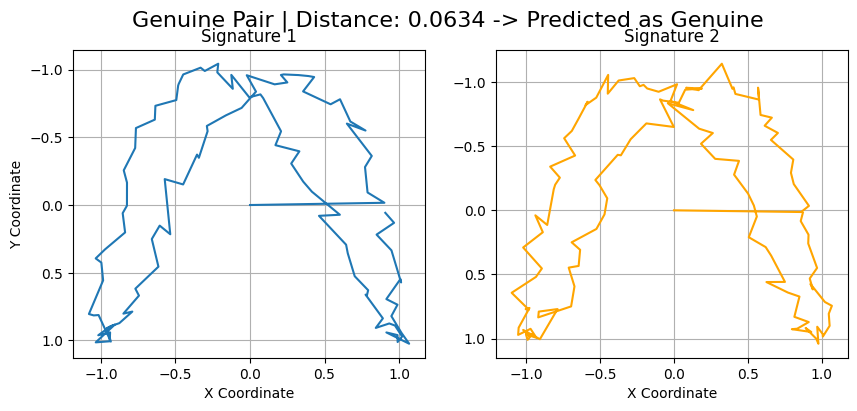


--- Testing a Forged Pair ---
Predicted Distance: 4.2484
Prediction: Forged (Correct: Forged)


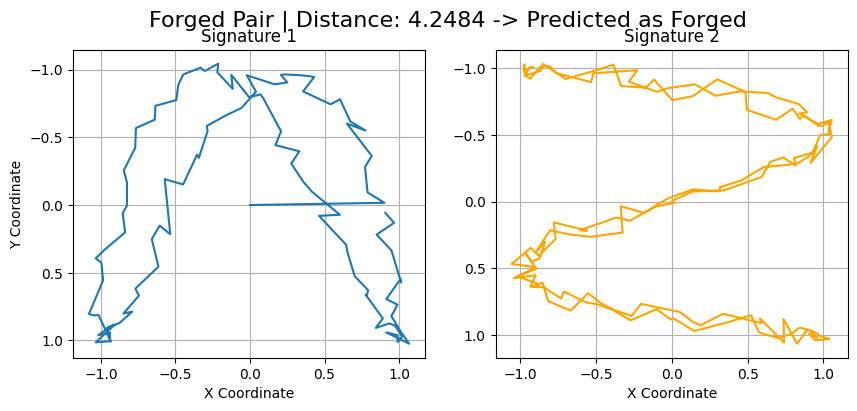

In [6]:
# --- Signature Visualization Function ---
# This helper function plots a pair of signatures side-by-side. It takes
# the raw signature data and renders it as a line plot, with the y-axis
# inverted to visually mimic a real signature on paper.

def plot_signatures(sig1, sig2, title):
    """A helper function to visualize a pair of signatures side-by-side."""

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sig1[:, 0], sig1[:, 1], label='Signature 1')
    plt.gca().invert_yaxis()
    plt.title("Signature 1")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(sig2[:, 0], sig2[:, 1], label='Signature 2', color='orange')
    plt.gca().invert_yaxis()
    plt.title("Signature 2")
    plt.xlabel("X Coordinate")
    plt.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.show()

# --- Model Evaluation and Testing ---
# This section demonstrates how to use the trained Siamese network for
# signature verification. The model's predictions (distance scores) are
# generated for the entire validation set and then compared against a
# predefined threshold to classify pairs as 'Genuine' or 'Forged'.
predictions = siamese_model.predict([X_val_1, X_val_2])
THRESHOLD = 0.25

# --- ✅ Test with a genuine pair from the validation set ---
# Find the index of the first pair in our validation set with a "genuine" label (1).
genuine_pair_index = np.where(y_val == 1)[0][0]
sig1_gen = X_val_1[genuine_pair_index]
sig2_gen = X_val_2[genuine_pair_index]
distance_gen = predictions[genuine_pair_index][0]
result_gen = "Genuine" if distance_gen < THRESHOLD else "Forged"

print(f"--- Testing a Genuine Pair ---")
print(f"Predicted Distance: {distance_gen:.4f}")
print(f"Prediction: {result_gen} (Correct: Genuine)")
plot_signatures(sig1_gen, sig2_gen, f"Genuine Pair | Distance: {distance_gen:.4f} -> Predicted as {result_gen}")



# --- ❌ Test with a forged pair from the validation set ---
# Find the index of the first pair in our validation set with a "forged" label (0).
forged_pair_index = np.where(y_val == 0)[0][0]
sig1_forged = X_val_1[forged_pair_index]
sig2_forged = X_val_2[forged_pair_index]
distance_forged = predictions[forged_pair_index][0]
result_forged = "Genuine" if distance_forged < THRESHOLD else "Forged"

print(f"\n--- Testing a Forged Pair ---")
print(f"Predicted Distance: {distance_forged:.4f}")
print(f"Prediction: {result_forged} (Correct: Forged)")
plot_signatures(sig1_forged, sig2_forged, f"Forged Pair | Distance: {distance_forged:.4f} -> Predicted as {result_forged}")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_realistic_mock_signature(num_points=200, complexity=5, jitter=0.003, seed_offset=0):
    """Generates a realistic mock signature with dynamic speed and pressure."""
    t = np.linspace(0, 2 * np.pi, num_points)
    x = np.zeros(num_points); y = np.zeros(num_points)
    np.random.seed(42 + seed_offset)
    for i in range(1, complexity + 1):
        x += (np.random.randn() * np.sin(i * np.random.randn() * t + np.random.randn()))
        y += (np.random.randn() * np.cos(i * np.random.randn() * t + np.random.randn()))
    dx = np.gradient(x); dy = np.gradient(y)
    curvature = np.abs(dx * np.gradient(dy) - dy * np.gradient(dx)) / ((dx**2 + dy**2)**1.5 + 1e-9)
    dt = 0.01 + 0.05 * (1 - np.tanh(curvature))
    pressure = np.clip(0.3 + 0.7 * (1 - np.tanh(dy * 5)), 0.1, 1.0)
    x += np.random.normal(0, jitter, num_points); y += np.random.normal(0, jitter, num_points)
    return np.vstack([x, y, pressure, dt]).T

def create_convincing_forgery(genuine_signature):
    """Creates a visually plausible forgery with different dynamic statistics."""
    forgery = np.flip(genuine_signature, axis=0)
    forgery[:, 3] = forgery[:, 3] * 1.8  # Make it 80% slower
    forgery[:, 2] = np.clip(np.random.normal(0.9, 0.02, len(forgery)), 0.85, 0.95)
    return forgery

# --- Helper functions for prediction ---
def normalize_signature(signature):
    """Translates and scales a signature."""
    sig = np.array(signature, dtype=np.float32)
    coords = sig[:, :2]
    coords -= np.min(coords, axis=0)
    max_val = np.max(np.max(coords, axis=0))
    if max_val > 0: coords /= max_val
    sig[:, :2] = coords
    return sig

def calculate_signature_stats(signature):
    """Calculates dynamic statistics for a signature."""
    if len(signature) < 2: return {}
    pressure = signature[:, 2]; dt = signature[:, 3]
    stats = {
        "Number of Points": len(signature), "Total Duration (s)": np.sum(dt),
        "Avg. Speed (s/pt)": np.mean(dt), "Speed Variation": np.std(dt),
        "Avg. Pressure": np.mean(pressure), "Pressure Variation": np.std(pressure),
    }
    return {k: round(v, 4) for k, v in stats.items()}

## 7. Explainable AI: The Detailed Comparison Report 🧠
To understand why the model makes a certain decision, we move beyond a simple verdict and generate a detailed explainable AI (XAI) report. This final section uses a technique called Occlusion Analysis to probe the model and visualize its reasoning.

The function generates a comprehensive 3x2 report that provides a complete story for any signature comparison:

Occlusion Analysis Heatmaps: The top row visualizes the most critical parts of each signature's path. "Hot" colors (yellow/green) indicate the areas the model focused on most, revealing its "thought process."

Dynamic Feature Plots: The middle row directly compares the pressure and speed profiles of the two signatures over time, making it easy to spot unnatural hesitations or inconsistent pressure in a forgery.

Quantitative Summary: The bottom row presents the final verdict in a clear, color-coded format, alongside a table of key dynamic statistics for a quantitative comparison.

This provides a complete, easy-to-understand explanation for the model's final decision.

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# This assumes you have the following functions defined:
# - calculate_signature_stats()
# And your trained `base_network` and `siamese_model`, plus `MAX_LEN` and `THRESHOLD`.

def generate_final_enhanced_report(sig1, sig2, sig1_name, sig2_name, base_network, siamese_model, max_len, threshold):
    """
Generates a final, enhanced report with a professional layout, dynamic plots, and clear indicators.

This comprehensive function creates a detailed, multi-panel report that not only provides a
final verdict on a signature pair but also offers insights into how the model arrived at
its decision by visualizing key features and performing explainable AI (XAI) analysis.
"""

    print(f"\n--- Generating Final Enhanced Report: {sig1_name} vs. {sig2_name} ---")

    # --- 1. Prediction and Statistics ---
# This section processes the input signatures, predicts their similarity using the
# Siamese network, and calculates a set of dynamic metrics (e.g., speed, pressure)
# that will be used for visualization and comparison in the report.

    input_sig1_padded = pad_sequences([sig1], maxlen=max_len, dtype='float32', padding='post')
    input_sig2_padded = pad_sequences([sig2], maxlen=max_len, dtype='float32', padding='post')
    distance = siamese_model.predict([input_sig1_padded, input_sig2_padded], verbose=0)[0][0]
    verdict = "Genuine" if distance < threshold else "Forged"
    stats1 = calculate_signature_stats(sig1); stats2 = calculate_signature_stats(sig2)

    # --- 2. Create the Report Layout (3 rows, 2 columns) ---
# This sets up a professional-looking figure with a custom grid layout.
# The different subplot sizes are chosen to best accommodate the various plots.

    fig, axes = plt.subplots(3, 2, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 2, 1.5]})
    fig.suptitle(f"Explainable AI Signature Report", fontsize=22, weight='bold')
    fig.tight_layout(pad=6.0)

    # --- 3. Occlusion Analysis Plots ---
# These plots perform a simple form of explainable AI. By temporarily "occluding"
# small segments of the signature and measuring the impact on the embedding,
# the model highlights which parts of the signature are most important for
# its decision-making. The color intensity of the signature line represents this importance.

    for ax, sig, name in [(axes[0, 0], sig1, sig1_name), (axes[0, 1], sig2, sig2_name)]:
        ax.set_title(f"Occlusion Analysis for {name}", fontsize=14)
        input_sig = pad_sequences([sig], maxlen=max_len, dtype='float32', padding='post')
        original_embedding = base_network.predict(input_sig, verbose=0)
        scores = np.zeros(len(sig))
        for i in range(len(sig) - 5 + 1):
            perturbed = input_sig.copy(); perturbed[0, i:i+5, :] = 0.0
            perturbed_embedding = base_network.predict(perturbed, verbose=0)
            scores[i:i+5] += np.linalg.norm(original_embedding - perturbed_embedding)
        if np.max(scores) > 0: scores /= np.max(scores)

        points = sig[:, :2].reshape(-1, 1, 2); segments = np.concatenate([points[:-1], points[1:]], axis=1)
        cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)

        for i in range(len(segments)):
            avg_importance = (scores[i] + scores[i+1]) / 2
            ax.plot(segments[i][:, 0], segments[i][:, 1], color=cmap(avg_importance), linewidth=3.5)
        ax.grid(True); ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")

# --- 4. Dynamic Feature Plots ---
# These plots provide a direct, side-by-side comparison of the two signatures'
# dynamic characteristics—pressure and speed—over time. These are crucial
# features that the network learns from, and their differences are often
# telltale signs of a forgery.

    ax_pressure = axes[1, 0]
    ax_pressure.plot(sig1[:, 2], label=sig1_name)
    ax_pressure.plot(sig2[:, 2], label=sig2_name, linestyle='--')
    ax_pressure.set_title("Pressure Profile Over Time", fontsize=14); ax_pressure.set_xlabel("Time Step"); ax_pressure.set_ylabel("Pressure")
    ax_pressure.legend(); ax_pressure.grid(True)

    ax_speed = axes[1, 1]
    ax_speed.plot(sig1[:, 3], label=sig1_name)
    ax_speed.plot(sig2[:, 3], label=sig2_name, linestyle='--')
    ax_speed.set_title("Speed Profile Over Time (dt)", fontsize=14); ax_speed.set_xlabel("Time Step"); ax_speed.set_ylabel("Time Delta (s)")
    ax_speed.legend(); ax_speed.grid(True)

# --- 5. Final Verdict & Stats Table ---
# This final panel presents the model's conclusion and a quantitative summary
# of the dynamic features. It shows the calculated distance, the verdict (genuine/forged),
# and a comparison table of the statistical metrics for each signature.

    ax_verdict = axes[2, 0]
    ax_verdict.axis('off'); ax_verdict.set_title("Prediction Summary", fontsize=14)
    ax_verdict.text(0.5, 0.6, f"Model Verdict: {verdict}", ha='center', va='center', fontsize=22, color='green' if verdict == "Genuine" else 'red', weight='bold')
    ax_verdict.text(0.5, 0.3, f"Calculated Distance: {distance:.4f} (Threshold: {threshold:.4f})", ha='center', va='center', fontsize=14)

    ax_stats = axes[2, 1]
    ax_stats.axis('off'); ax_stats.set_title("Dynamic Statistics Comparison", fontsize=14)
    table_data = [[key, stats1.get(key, 'N/A'), stats2.get(key, 'N/A')] for key in stats1]
    table = ax_stats.table(cellText=table_data, colLabels=["Metric", sig1_name, sig2_name], loc='center', cellLoc='center')
    table.auto_set_font_size(False); table.set_fontsize(11); table.scale(1, 1.8)

    plt.show()

## Report 1: Genuine vs. Skilled Forgery

--- Generating Signatures for the Final Demo ---

--- Generating Final Enhanced Report: Dr. Reed (Genuine) vs. Skilled Forgery ---


/tmp/ipython-input-3486455665.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)


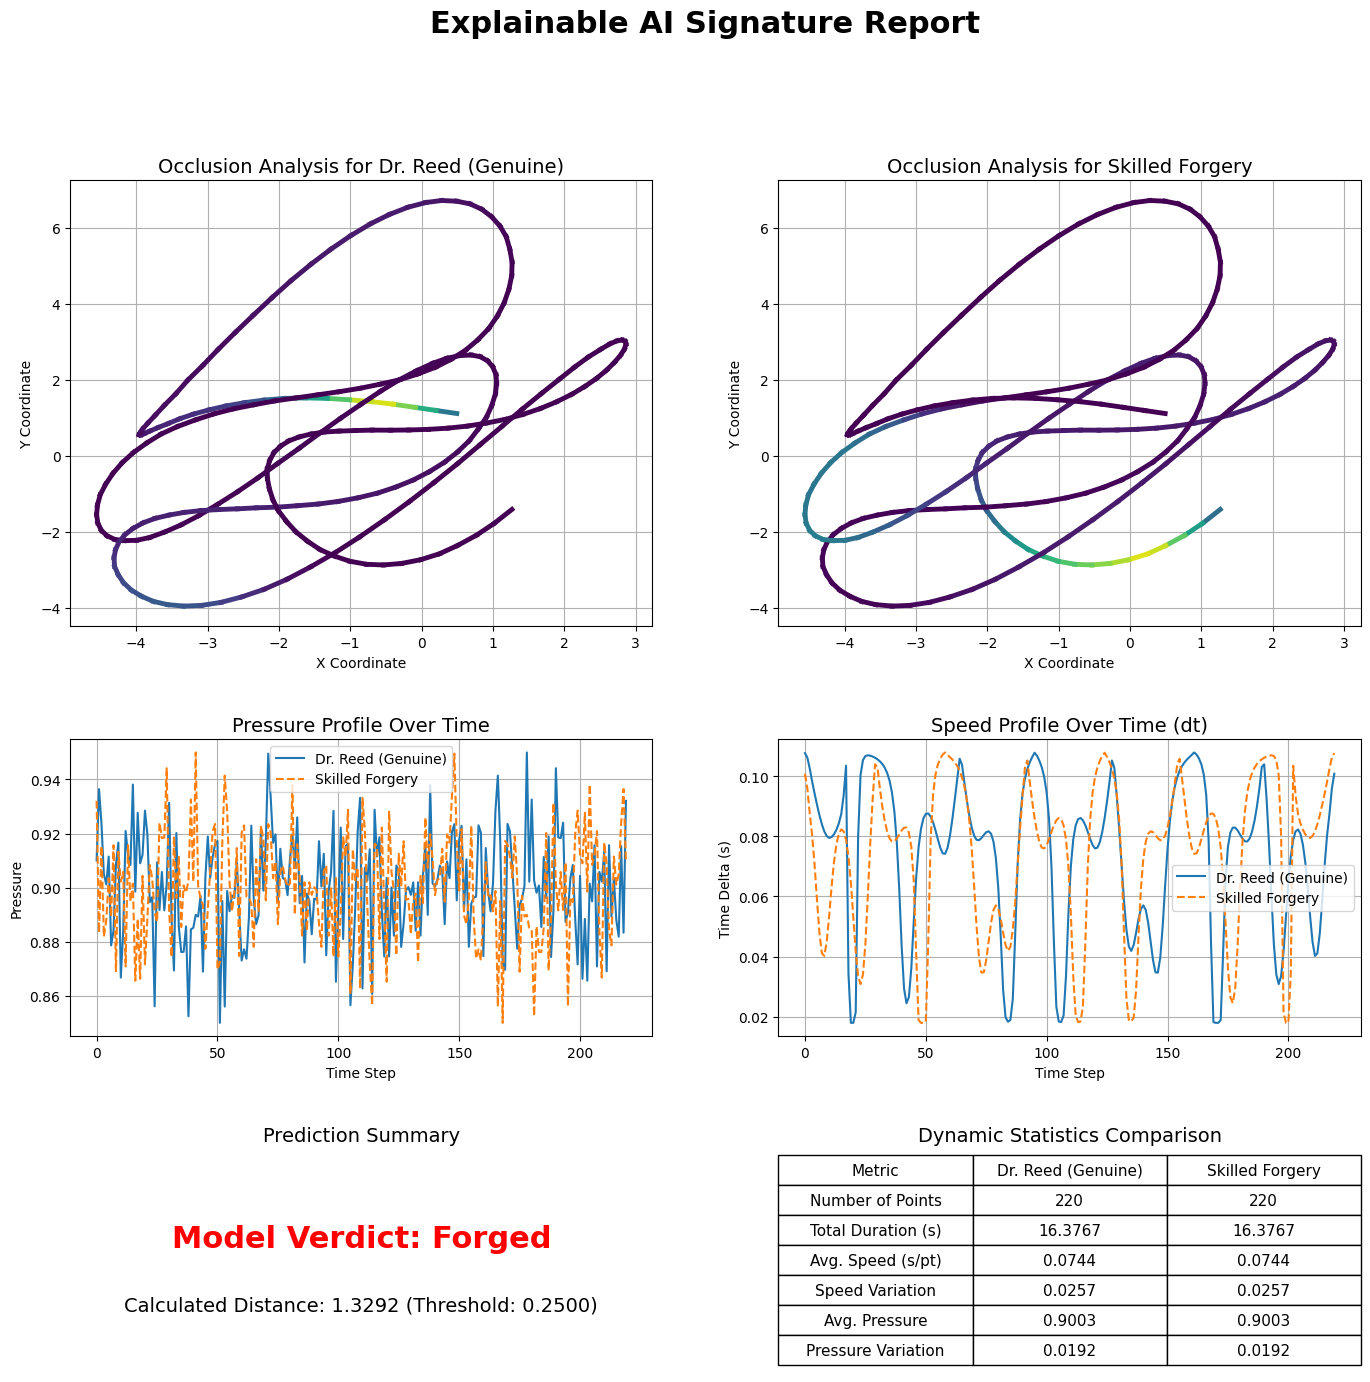

In [9]:
print("--- Generating Signatures for the Final Demo ---")

# 1. Create the genuine signature for Dr. Reed
dr_reed_signature = generate_realistic_mock_signature(
    num_points=220,
    complexity=6,
    jitter=0.0025,
    seed_offset=250
)

# 2. Create a skilled forgery of Dr. Reed's signature
forgery_of_reed = create_convincing_forgery(dr_reed_signature)

# 3. Call the report function with the newly created signatures
generate_final_enhanced_report(
    sig1=dr_reed_signature,
    sig2=forgery_of_reed,
    sig1_name="Dr. Reed (Genuine)",
    sig2_name="Skilled Forgery",
    base_network=base_network,
    siamese_model=siamese_model,
    max_len=MAX_LEN,
    threshold=THRESHOLD
)

## Report 2: Genuine vs. Different Person

--- Generating Signatures for 'Genuine vs. Different Person' Report ---

--- Generating Final Enhanced Report: Dr. Reed (Genuine) vs. Mr. Khan (Different) ---


/tmp/ipython-input-3486455665.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)


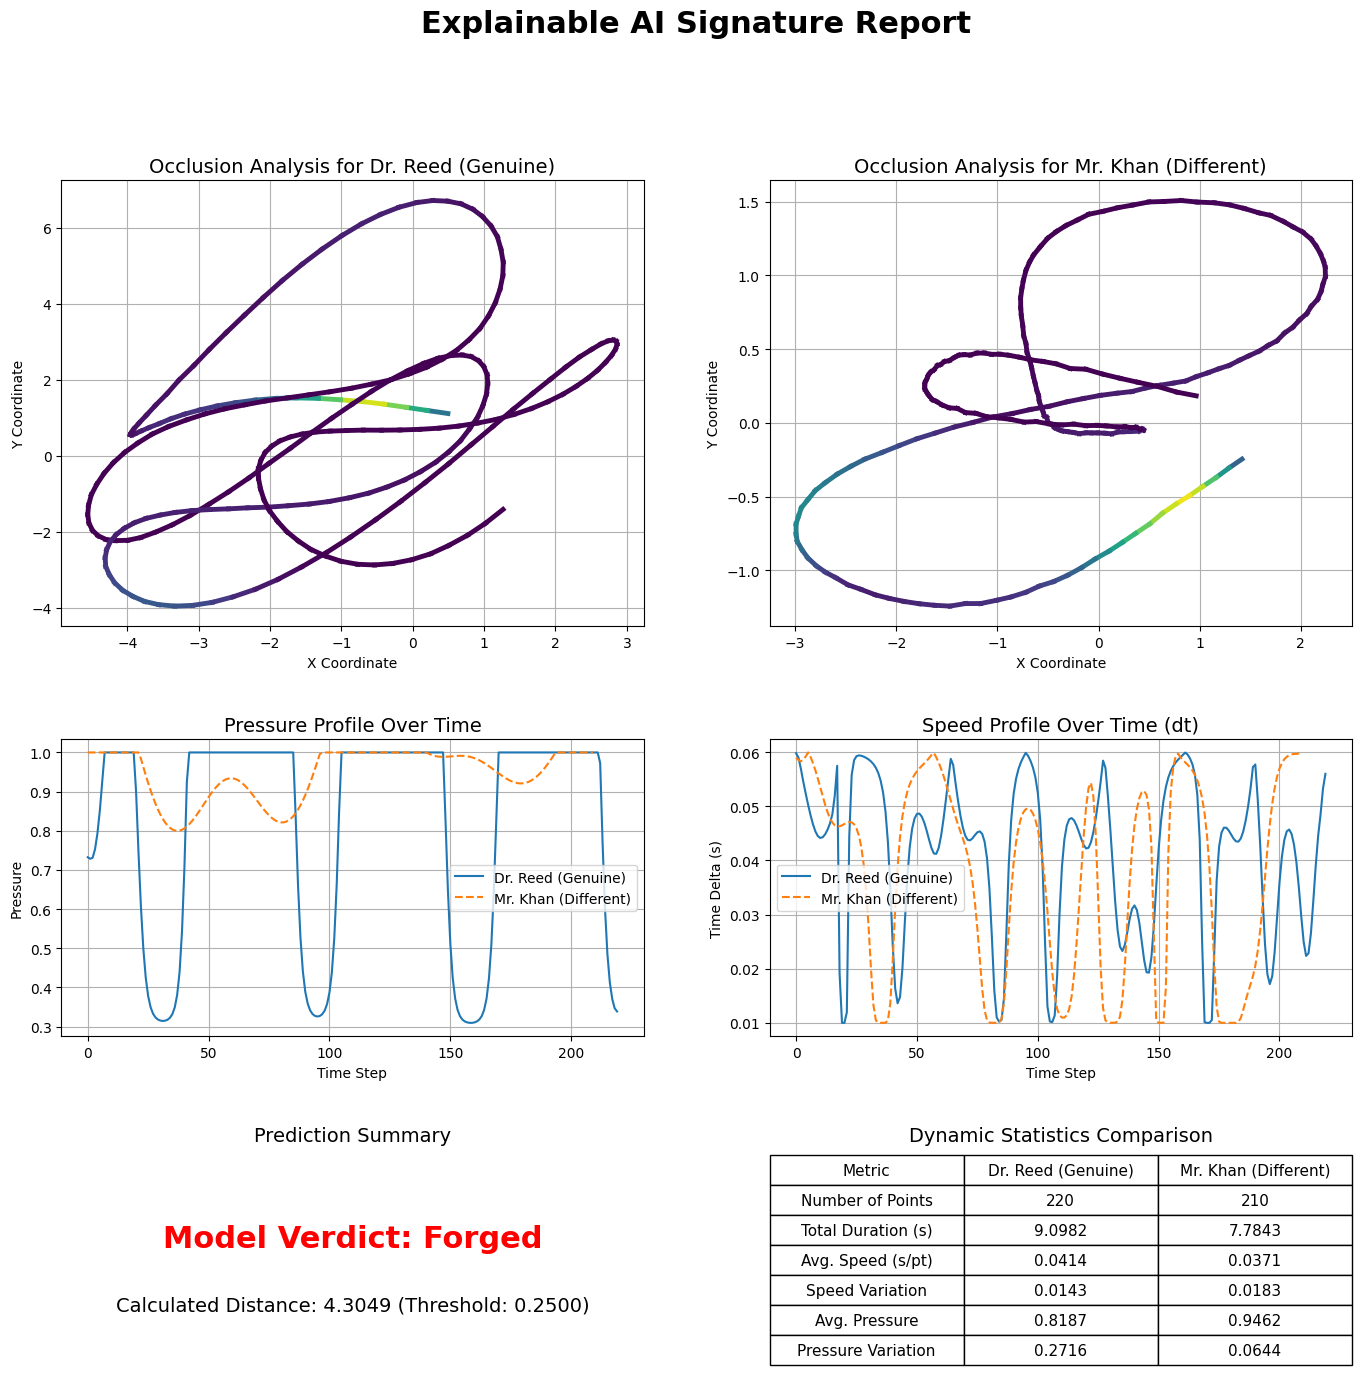

In [10]:
print("--- Generating Signatures for 'Genuine vs. Different Person' Report ---")

# 1. Generate the genuine signature for Dr. Reed
dr_reed_signature = generate_realistic_mock_signature(
    num_points=220,
    complexity=6,
    jitter=0.0025,
    seed_offset=250
)

# 2. Generate a signature for a completely different person, Mr. Khan
mr_khan_signature = generate_realistic_mock_signature(
    num_points=210,
    complexity=5,
    jitter=0.004,
    seed_offset=300 # Using a different seed_offset creates a different style
)

# 3. Call the report function
generate_final_enhanced_report(
    sig1=dr_reed_signature,
    sig2=mr_khan_signature,
    sig1_name="Dr. Reed (Genuine)",
    sig2_name="Mr. Khan (Different)",
    base_network=base_network,
    siamese_model=siamese_model,
    max_len=MAX_LEN,
    threshold=THRESHOLD
)

## Report 3: Genuine vs. Genuine

--- Generating Signatures for 'Genuine vs. Genuine' Report ---

--- Generating Final Enhanced Report: Dr. Reed (Signature 1) vs. Dr. Reed (Signature 2) ---


/tmp/ipython-input-3486455665.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)


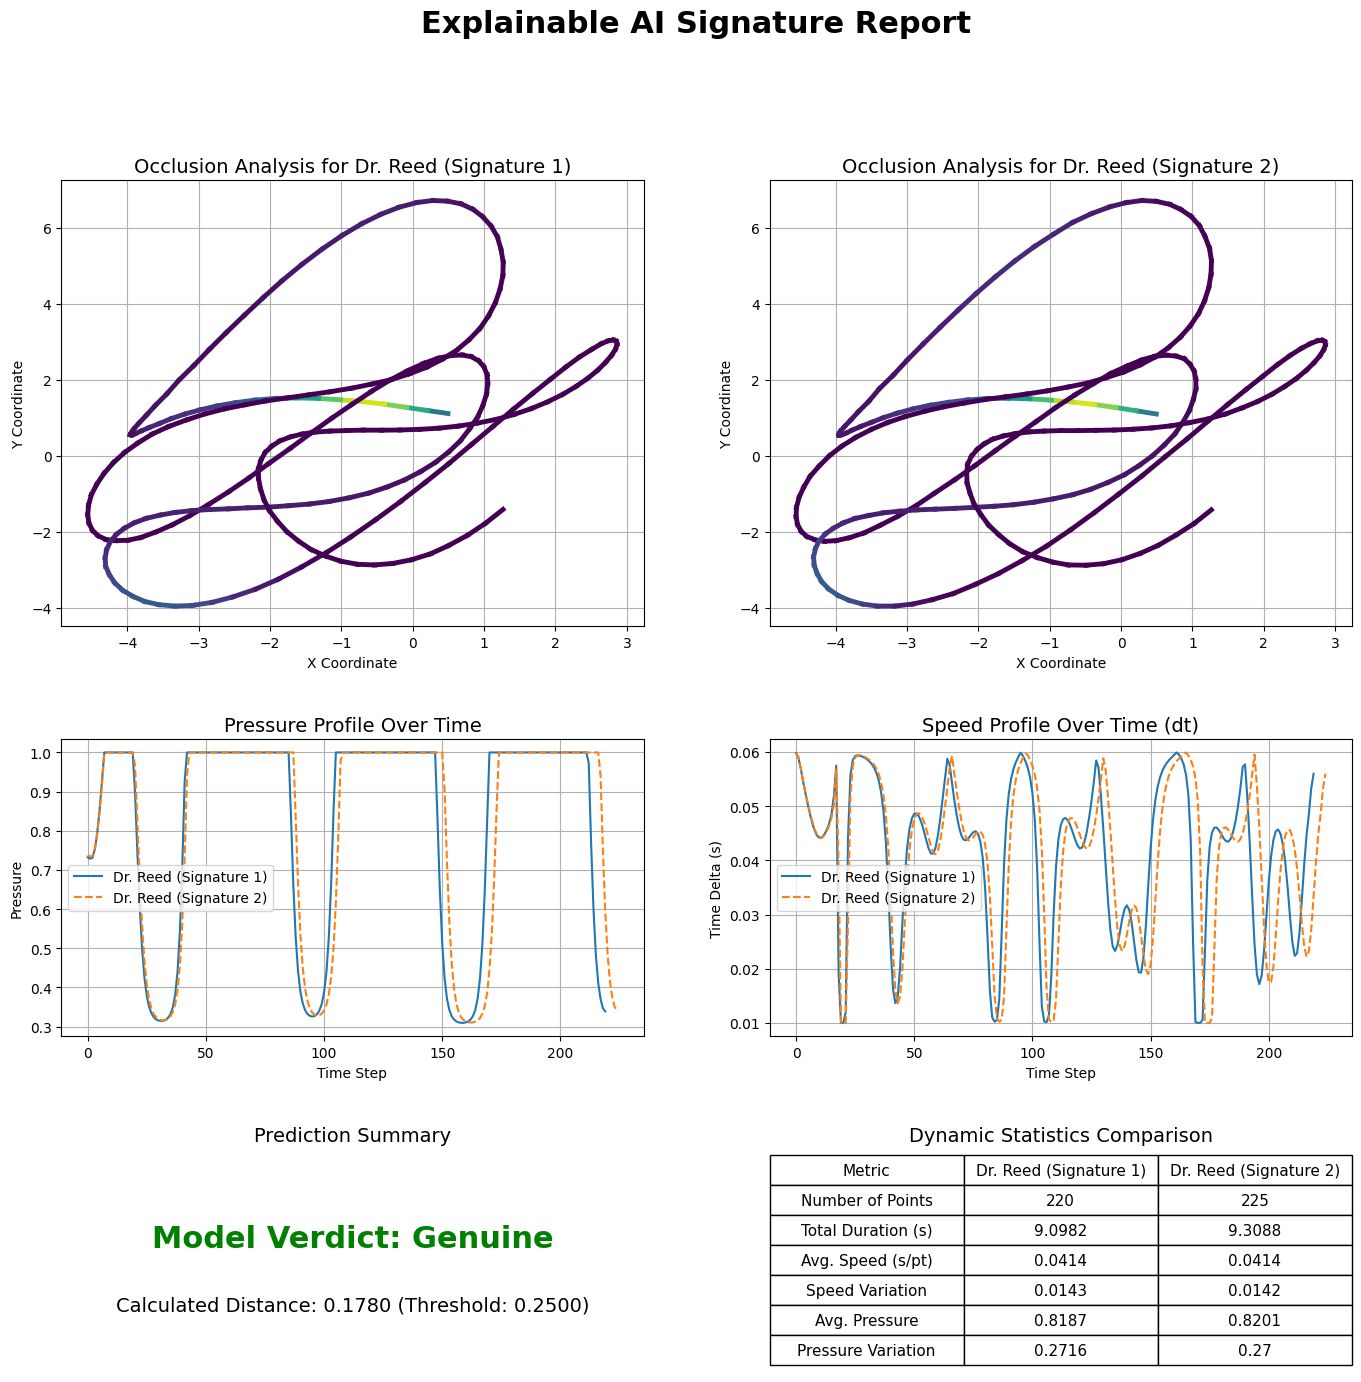

In [11]:
print("--- Generating Signatures for 'Genuine vs. Genuine' Report ---")

# 1. Generate the first genuine signature for Dr. Reed.
dr_reed_signature_1 = generate_realistic_mock_signature(
    num_points=220,
    complexity=6,
    jitter=0.0025,
    seed_offset=250
)

# 2. Generate a SECOND genuine signature for the same person.
# The SAME seed_offset ensures the same style, but different jitter/length creates natural variation.
dr_reed_signature_2 = generate_realistic_mock_signature(
    num_points=225,
    complexity=6,
    jitter=0.003,
    seed_offset=250
)

# 3. Call the report function
generate_final_enhanced_report(
    sig1=dr_reed_signature_1,
    sig2=dr_reed_signature_2,
    sig1_name="Dr. Reed (Signature 1)",
    sig2_name="Dr. Reed (Signature 2)",
    base_network=base_network,
    siamese_model=siamese_model,
    max_len=MAX_LEN,
    threshold=THRESHOLD
)